Pretrain model(LLAMA)

Non-instruction finetuning on plaine text

intruction finetuning on instruciton dataset

prefrence aligment


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType
from datasets import load_dataset

In [ ]:
model = "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

In [ ]:
import zipfile
import os
# Path to your zip file
zip_path = "/content/tinyllama-lora.zip"

# Extract all files
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
model_path = "/content/checkpoint-5"

In [ ]:
non_instruction_model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")

In [ ]:
prompt = "Clinical trials demonstrated that combining Atorvastatin with Ezetimibe"

In [ ]:
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

In [ ]:
outputs = non_instruction_model.generate(
    **inputs,
    max_new_tokens=100,
    temperature=0.8,
    top_p=0.9,
    do_sample=True,
    repetition_penalty=1.1
)

In [ ]:
print("\nModel Output:\n")
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

We have learn till here

Now lets start with instructin finetuning

first of all lets inspect the data

I am starting with inbuilt data

In [ ]:
from datasets import load_dataset
dataset = load_dataset("Amod/mental_health_counseling_conversations", split="train")

In [ ]:
dataset

In [ ]:
def format_row(example):
    question = example["Context"]
    answer = example["Response"]
    example["Text"] = f"[INST] {question} [/INST] {answer}"
    return example

In [ ]:
def format_row(example):
    question = example["Context"]
    answer = example["Response"]
    example["Text"] = f"[Context] {question} [/Response] {answer}"
    return example

In [ ]:
formatted_dataset = dataset.map(format_row)

In [ ]:
formatted_dataset

In [ ]:
print(formatted_dataset[0]["Text"])

In [ ]:
import pandas as pd

# Convert dataset to DataFrame
df = pd.DataFrame(dataset)

In [ ]:
df

In [ ]:
df.to_csv("mental_health_counseling_conversations.csv", index=False)

In [ ]:
df.to_json("mental_health_counseling_conversations.jsonl", orient="records", lines=True)

In [ ]:
from datasets import load_dataset

dataset = load_dataset("csv", data_files="mental_health_counseling_conversations.csv",split="train")
dataset


In [ ]:
from datasets import load_dataset

dataset = load_dataset("json", data_files="mental_health_counseling_conversations.jsonl", split="train")
dataset

till here the data loading part is clear i think

# now lets load our data

In [ ]:
from datasets import load_dataset

dataset = load_dataset("csv", data_files="/content/pharma_instruction_data.csv",split="train")
dataset


In [ ]:
def format_example(example):
    prompt = f"### Instruction:\n{example['instruction']}\n### Input:\n{example['input']}\n### Response:\n{example['output']}"
    return {"text": prompt}

In [ ]:
dataset = dataset.map(format_example)

In [ ]:
dataset

In [ ]:
dataset['text'][0]

### Instruction:\nExplain the mechanism of action of Metformin.\n### Input:\nNone\n### Response:\nMetformin activates AMP-activated protein kinase (AMPK), which increases glucose uptake and fatty-acid oxidation while inhibiting hepatic gluconeogenesis, thereby lowering blood glucose.

In [ ]:
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

In [ ]:
def tokenize_fn(example):
    tokens = tokenizer(example["text"], truncation=True, padding="max_length", max_length=512)
    tokens["labels"] = tokens["input_ids"].copy()
    return tokens

In [ ]:
tokenized = dataset.map(tokenize_fn, batched=True)

In [ ]:
from peft import LoraConfig, get_peft_model, TaskType

| Parameter        | Meaning                     | Typical Value         | Effect                           |
| ---------------- | --------------------------- | --------------------- | -------------------------------- |
| `task_type`      | Model type (Causal/Seq2Seq) | `CAUSAL_LM`           | Ensures correct integration      |
| `r`              | Rank of LoRA matrix         | 4–16                  | Controls trainable param size    |
| `lora_alpha`     | Scaling factor              | 16–64                 | Balances adaptation strength     |
| `lora_dropout`   | Dropout probability         | 0.05                  | Regularization                   |
| `target_modules` | Which layers to tune        | `["q_proj","v_proj"]` | Trade-off between cost & quality |
| `bias`           | Bias fine-tuning            | `"none"`              | Keep simple                      |


In [ ]:
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=["q_proj", "v_proj"],
    bias="none"
)

In [ ]:
instruction_model = get_peft_model(non_instruction_model, lora_config)

In [ ]:
# #STEP A: Load base model
# model = AutoModelForCausalLM.from_pretrained(...)
# #STEP B: Load Stage-1 LoRA
# model = PeftModel.from_pretrained(model, non_instruction_model)
# model = model.merge_and_unload()
# # Why merge?
# # → Model clean + LoRA applied inside weights
# # → Now you can attach SECOND LoRA cleanly
# #STEP C: Attach NEW LoRA for instruction
# instruction_model_lora = get_peft_model(model, lora_config)

In [ ]:
args = TrainingArguments(
    output_dir="./tinyllama-instruction",
    num_train_epochs=3,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    learning_rate=2e-4,
    fp16=True,
    logging_steps=20,
    save_total_limit=1,
    report_to="none"
)


In [ ]:
trainer = Trainer(
    model=instruction_model_lora,
    args=args,
    train_dataset=tokenized,
)

In [ ]:
trainer.train()

In [ ]:
model_path = "/content/tinyllama-instruction/checkpoint-3"

In [ ]:
instruction_model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")

In [ ]:
prompt = "Explain the mechanism of action of Metformin."

In [ ]:
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

In [ ]:
outputs = instruction_model.generate(
    **inputs,
    max_new_tokens=100,
    temperature=0.8,
    top_p=0.9,
    do_sample=True,
    repetition_penalty=1.1
)

In [ ]:
print("\nModel Output:\n")
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

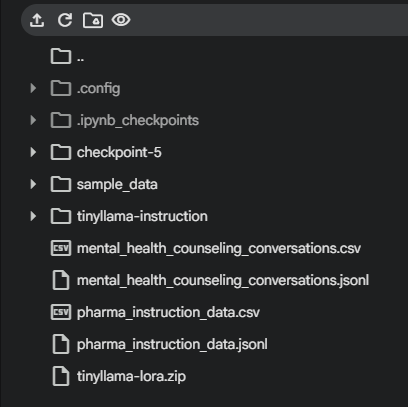

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType
import torch

# Load dataset
dataset = load_dataset("csv", data_files="/content/pharma_instruction_data.csv", split="train")
print(dataset)


# Format dataset to Alpaca-style text
def format_example(example):
    # Build unified instruction-style prompt
    prompt = f"### Instruction:\n{example['instruction']}\n### Input:\n{example['input']}\n### Response:\n{example['output']}"
    return {"text": prompt}

dataset = dataset.map(format_example)
print(dataset[0]["text"])


# Tokenizer setup
tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


# Tokenization with Response Masking
def tokenize_and_mask(example):
    text = example["text"]

    # Tokenize full text
    enc = tokenizer(text, truncation=True, padding="max_length", max_length=512)
    input_ids = enc["input_ids"]

    # Find where '### Response:' starts
    response_marker = "### Response:"
    response_start = text.find(response_marker)

    if response_start != -1:
        # Token index where response begins
        response_token_start = len(tokenizer(text[:response_start])["input_ids"])
    else:
        response_token_start = 0  # if marker not found

    # Clone labels and mask out everything before 'Response'
    labels = input_ids.copy()
    labels[:response_token_start] = [-100] * response_token_start

    enc["labels"] = labels
    return enc

# Apply tokenization
tokenized = dataset.map(tokenize_and_mask, batched=False)
print("Tokenization + masking done.")


# LoRA config
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=["q_proj", "v_proj"],
    bias="none"
)


# Load base model (previously non-instructional trained)
non_instructional_trained_model = AutoModelForCausalLM.from_pretrained(
    "path_to_your_non_instruction_model",
    torch_dtype=torch.float16,
    device_map="auto"
)

model = get_peft_model(non_instructional_trained_model, lora_config)

# Training setup
args = TrainingArguments(
    output_dir="./tinyllama-instruction",
    num_train_epochs=3,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    learning_rate=2e-4,
    fp16=True,
    logging_steps=20,
    save_total_limit=1,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized,
)


# Train the model
trainer.train()


# Save & test the model
trainer.save_model("/content/tinyllama-instruction")
tokenizer.save_pretrained("/content/tinyllama-instruction")

# Test generation
trained_model = AutoModelForCausalLM.from_pretrained("/content/tinyllama-instruction", device_map="auto")

prompt = "### Instruction:\nWhat is Ezetimibe?\n### Input:\n\n### Response:\n"
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

outputs = trained_model.generate(
    **inputs,
    max_new_tokens=100,
    temperature=0.8,
    top_p=0.9,
    do_sample=True,
    repetition_penalty=1.1
)

print("\nModel Output:\n")
print(tokenizer.decode(outputs[0], skip_special_tokens=True))


In [ ]:
questions = [
    "Explain the mechanism of action of Metformin.",
    "List two advantages of combining Atorvastatin with Ezetimibe.",
    "Summarize how mRNA vaccines work and mention one current research focus."
]

In [ ]:
for q in questions:
    print("Question:", q)
    print("\n--- Non-instruction model ---")
    inputs = tokenizer(q, return_tensors="pt").to("cuda")
    outputs = non_instruction_model.generate(**inputs, max_new_tokens=80)
    print(tokenizer.decode(outputs[0], skip_special_tokens=True))

    print("\n--- Instruction-tuned model ---")
    prompt = f"### Instruction:\n{q}\n### Input:\n\n### Response:\n"
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = instruction_model.generate(**inputs, max_new_tokens=100)
    print(tokenizer.decode(outputs[0], skip_special_tokens=True))
    print("="*80, "\n")
